In [205]:
from pybaseball import statcast
from pybaseball import pitching_stats_bref
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Loads in all of the Statcast data from the years 2016, 2017, 2018, 2021, 2022

In [206]:
savant_df2016 = statcast(start_dt = "2016-03-28", end_dt = "2016-11-15")

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


  0%|          | 0/214 [00:00<?, ?it/s]

100%|██████████| 214/214 [00:40<00:00,  5.25it/s]


In [207]:
savant_df2017 = statcast(start_dt = "2017-03-28", end_dt = "2017-11-15")

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 214/214 [00:45<00:00,  4.66it/s]


In [208]:
savant_df2018 = statcast(start_dt = "2018-03-28", end_dt = "2018-11-15")

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 214/214 [00:44<00:00,  4.85it/s]


In [209]:
savant_df2021 = statcast(start_dt = "2021-03-28", end_dt = "2021-11-15")

This is a large query, it may take a moment to complete


100%|██████████| 233/233 [00:51<00:00,  4.50it/s]


In [210]:
savant_df2022 = statcast(start_dt = "2022-03-28", end_dt = "2022-11-15")

This is a large query, it may take a moment to complete


100%|██████████| 233/233 [00:51<00:00,  4.57it/s]


### Concatenates the Statcast data together to make one giant dataset

In [211]:
expected = pd.concat([savant_df2016, savant_df2017, savant_df2018, savant_df2021, savant_df2022], axis = 0)

### Groups by the events/batted ball types and the expected run value of each occurence

In [212]:
expected_grouped1 = expected.groupby(['events']).agg(
    Run_Value = ('delta_run_exp', 'mean'))

expected_grouped1

,Run_Value
events,
catcher_interf,0.382442
caught_stealing_2b,-0.209388
caught_stealing_3b,-0.335937
caught_stealing_home,-0.290938
double,0.764403
double_play,-0.359216
ejection,-0.1965
field_error,0.448989
field_out,-0.235644


In [213]:
expected_grouped2 = expected.groupby(['bb_type']).agg(
    Run_Value = ('delta_run_exp', 'mean'))

expected_grouped2

,Run_Value
bb_type,
fly_ball,0.100319
ground_ball,-0.061018
line_drive,0.295364
popup,-0.231931


### The expected run values for each outcome

In [214]:
K = -0.216668
BB = 0.218963
HBP = 0.373525
GB = -0.061018
LD = 0.295364
FB = 0.100319
PU = -0.231931

print(1/GB)

-16.38860664066341


### Loads in the Baseball Reference data from the years 2021 and 2022

In [215]:
bref2021 = pitching_stats_bref("2021")
bref2022 = pitching_stats_bref("2022")

bref2021 = bref2021.rename(columns={'ERA': 'ERA2021'})
bref2022 = bref2022.rename(columns={'ERA': 'ERA2022'})

bref2021 = bref2021[bref2021['IP'] >= 60]
bref2022 = bref2022[bref2022['IP'] >= 60]

In [216]:
savant_df2021 = savant_df2021.rename(columns={'player_name': 'Name', 'pitch_type': 'Pitch Type'})

In [217]:
def flip_names(name):
    first_name, last_name = name.split(", ")
    return f"{last_name} {first_name}"

savant_df2021['Name'] = savant_df2021["Name"].apply(flip_names)

### Groups by a pitchers' name and finds all the stats used to calculate sPRA

In [226]:
player_grouped2021 = savant_df2021.groupby(['Name']).agg(
    BB = ('events', lambda x: (x == 'walk').sum()),
    HBP = ('events', lambda x: (x == 'hit_by_pitch').sum()),
    K = ('events', lambda x: (x == 'strikeout').sum()),
    TBF = ('events', lambda x: (x.isin(['other_out', 'single', 'double', 'triple', 'home_run', 'walk', 'strikeout', 'field_out', 'hit_by_pitch', 'sac_fly', 'sac_fly_double_play', 'sac_bunt', 'field_error', 'fielders_choice', 'double_play', 'fielders_choice_out', 'sac_fly_double_play', 'strikeout_double_play', 'catcher_interf', 'triple_play', 'grounded_into_double_play'])).sum()),
    GB = ('bb_type', lambda x: (x == 'ground_ball').sum()),
    LD = ('bb_type', lambda x: (x == 'line_drive').sum()),
    FB = ('bb_type', lambda x: (x == 'fly_ball').sum()),
    PU = ('bb_type', lambda x: (x == 'popup').sum()),
    BIP = ('bb_type', lambda x: (x.isin(['ground_ball', 'line_drive', 'fly_ball', 'popup'])).sum()))

player_grouped2021 = player_grouped2021[player_grouped2021['TBF'] >= 230]
player_grouped2021

,BB,HBP,K,TBF,GB,LD,FB,PU,BIP
Name,,,,,,,,,
A.J. Minter,22,2,75,263,78,38,39,13,168
Aaron Bummer,27,4,82,251,109,16,14,3,142
Aaron Civale,32,4,99,505,173,87,93,26,379
Aaron Nola,38,9,223,739,199,115,129,35,478
Adam Cimber,13,7,53,276,113,44,37,20,214
...,...,...,...,...,...,...,...,...,...
Zach Pop,22,8,51,239,95,31,29,8,163
Zach Thompson,27,3,66,311,98,42,66,12,218
Zack Greinke,39,2,124,715,261,140,131,29,561


### The calculation and table being outputted of sPRA of the year 2021

In [227]:
player_grouped2021["sPRA2021"] = round(
    (0.85 * ((BB * 16.38860664066341 * player_grouped2021["BB"]) + (HBP * 16.38860664066341 * player_grouped2021["HBP"]) + (K * 16.38860664066341 * player_grouped2021["K"]) + 
    (FB * 16.38860664066341 * player_grouped2021["FB"]) + (LD * 16.38860664066341 * player_grouped2021["LD"]) + (PU * 16.38860664066341 * player_grouped2021["PU"]) + (GB * 16.38860664066341 * player_grouped2021["GB"]))
    / player_grouped2021["TBF"]) , 2) + 4.05
    
player_grouped2021 = player_grouped2021.sort_values(by = "sPRA2021")
player_grouped2021 = player_grouped2021.reset_index()
player_grouped2021 = player_grouped2021[["Name", "sPRA2021"]]
player_grouped2021

,Name,sPRA2021
0,Jacob deGrom,3.05
1,Liam Hendriks,3.24
2,Josh Hader,3.31
3,Aaron Bummer,3.41
4,Emmanuel Clase,3.48
...,...,...
304,Mitch Keller,4.63
305,Jaime Barria,4.64
306,Riley Smith,4.65
307,Chi Chi González,4.72


In [228]:
print(f"League Mean PRA is: {round(player_grouped2021['sPRA2021'].mean(), 3)}")
print(f"League Median PRA is: {round(player_grouped2021['sPRA2021'].median(), 3)}")

League Mean PRA is: 4.11
League Median PRA is: 4.13


### Merges the 2022 Baseball Reference and the sPRA tables together so Name, 2021 sPRA, and 2022 ERA can be displayed
* Drops Dallas Keuchel because his 2022 ERA is in the 9s and an outlier

In [229]:
final = pd.merge(bref2022, player_grouped2021, on='Name', how='left')
final.loc[:, "sPRA+"] =  round((np.mean(final["sPRA2021"]) / final["sPRA2021"]) * 100, 2)
final = final[["Name", "sPRA2021", "ERA2022", "sPRA+"]]
final = final.dropna()
final = final[final["Name"] != "Dallas Keuchel"]
final = final.sort_values(by = "sPRA2021")
final

,Name,sPRA2021,ERA2022,sPRA+
63,Jacob deGrom,3.05,3.08,134.35
48,Emmanuel Clase,3.48,1.36,117.75
208,Jordan Romano,3.49,2.11,117.41
38,Corbin Burnes,3.52,2.94,116.41
137,Michael Kopech,3.54,3.54,115.75
...,...,...,...,...
61,Zach Davies,4.55,4.09,90.06
265,Bryse Wilson,4.62,5.52,88.69
129,Mitch Keller,4.63,3.91,88.50
17,Jaime Barria,4.64,2.61,88.31


### Displays the 2021 sPRA against 2022 ERA on a scatter plot with a line of best fit going through the graph
### Also calculates and prints the R-squared value

0.1494763721275556


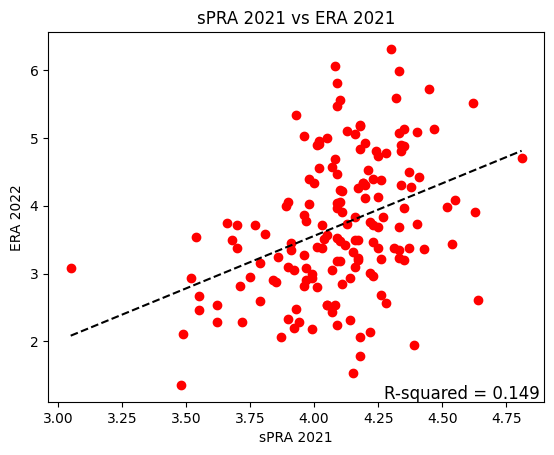

In [230]:
x = final["sPRA2021"].values.reshape(-1, 1)
y = final["ERA2022"].values.reshape(-1, 1)

model = LinearRegression().fit(x, y)
pred = model.predict(x)

print((np.corrcoef(final["sPRA2021"], final["ERA2022"])[0, 1]) ** 2)

plt.scatter(final["sPRA2021"], final["ERA2022"], color = "red")
plt.plot(x, pred, linestyle = "--", color = 'black',  label='Regression Line')

plt.xlabel("sPRA 2021")
plt.ylabel("ERA 2022")
plt.title("sPRA 2021 vs ERA 2021")
plt.text(4.88, 1.1, "R-squared = 0.149", fontsize = 12, color = 'black', va = 'bottom', ha = 'right')

#plt.savefig("sPRA.png")
plt.show()

final["Residuals"] = y - pred

### Calculates and prints out the Root Mean Squared Error (RMSE)

In [231]:
RMSE = np.sqrt(np.mean(final['Residuals']**2))
print(f"The RMSE is: {round((RMSE), 6)}")

The RMSE is: 0.934378
